# Investigate the effect of T2* on Kappa and Rho

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nilearn.glm import first_level
from scipy import signal, stats

from tedana.decay import monoexponential

sns.set_style("whitegrid")

/opt/miniconda3/envs/tedanapy311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_metrics(data, B, tes):
    """Compute kappa and rho without extra fanciness."""
    tes = tes[:, None]
    data = data[None, ...]
    B = B[:, None]
    n_echos = len(tes)
    alpha = (np.abs(B)**2).sum(axis=0)
    mu = np.mean(data, axis=-1)
    X1 = mu.T  # Model 1
    X2 = np.tile(tes, (1, 1)) * mu.T  # Model 2

    # S0 Model
    # (S,) model coefficient map
    coeffs_S0 = (B * X1).sum(axis=0) / (X1**2).sum(axis=0)
    pred_S0 = X1 * np.tile(coeffs_S0, (n_echos, 1))
    SSE_S0 = (B - pred_S0)**2
    SSE_S0 = SSE_S0.sum(axis=0)  # (S,) prediction error map
    F_S0 = (alpha - SSE_S0) * (n_echos - 1) / (SSE_S0)

    # R2 Model
    coeffs_R2 = (B * X2).sum(axis=0) / (X2**2).sum(axis=0)
    pred_R2 = X2 * np.tile(coeffs_R2, (n_echos, 1))
    SSE_R2 = (B - pred_R2)**2
    SSE_R2 = SSE_R2.sum(axis=0)
    F_R2 = (alpha - SSE_R2) * (n_echos - 1) / (SSE_R2)
    
    return F_S0, F_R2, pred_S0, pred_R2

In [3]:
# Echo time schemes to choose from

# For a nice, smooth curve
# echo_times = np.arange(0, 201, 1)

# logan's TEs
echo_times = np.array([9.58, 21.95, 34.32, 46.69, 59.06, 71.43, 83.8, 96.17])

# Round numbers
# echo_times = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# dan's TEs
# echo_times = np.array([15.4, 29.7, 44.0, 58.3, 72.6])

# 3-echo
# echo_times = np.array([15, 30, 45])

n_echoes = len(echo_times)
pal = sns.color_palette('cubehelix', n_echoes)

## Simulate data from various conditions
I'm creating a few conditions with the same base T2* value, but different levels of T2* fluctuation.
We can consider them something like various levels of the same stimulus (low, medium, and high pain?); hence the different effect sizes.

[[ 1.         -0.05798553 -0.05767884 -0.00511121]
 [-0.05798553  1.         -0.05798553 -0.00100949]
 [-0.05767884 -0.05798553  1.         -0.004713  ]
 [-0.00511121 -0.00100949 -0.004713    1.        ]]


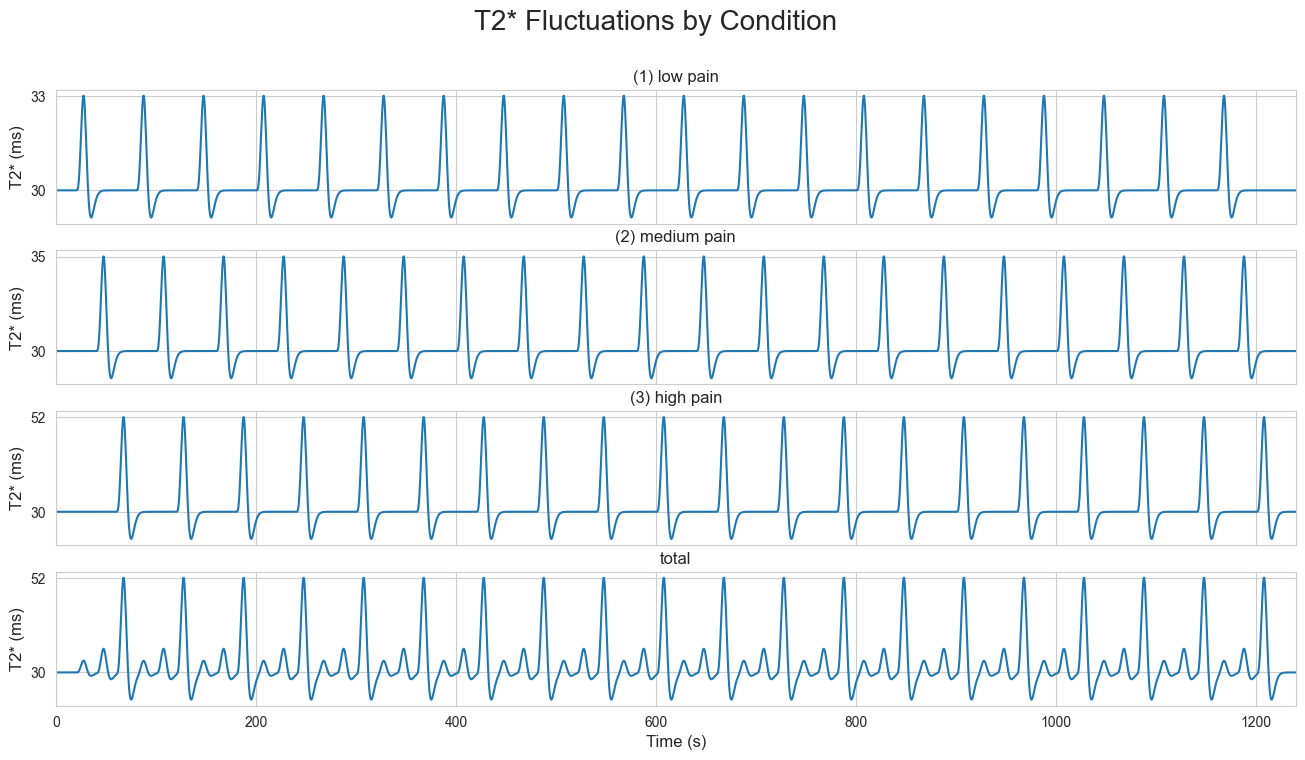

In [4]:
conditions = ["(1) low pain", "(2) medium pain", "(3) high pain"]
n_conditions = len(conditions)
n_trials_per_condition = 20
onsets1 = 20 + np.arange(n_trials_per_condition) * 60
onsets2 = 40 + np.arange(n_trials_per_condition) * 60
onsets3 = 60 + np.arange(n_trials_per_condition) * 60
trial_types = sorted(conditions * n_trials_per_condition)
df = pd.DataFrame(columns=['onset'], data=np.hstack((onsets1, onsets2, onsets3)))
df["duration"] = 5
df["trial_type"] = trial_types

t_r = 0.5
n_trs = int((df["onset"].max() + 40) // t_r)
frametimes = np.linspace(0, (n_trs - 1) * t_r, n_trs)
dm = first_level.make_first_level_design_matrix(
    frame_times=frametimes,
    events=df,
    drift_model=None,
    high_pass=None,
)
dm = dm[conditions]

t2star_dm = dm.values.copy()  # conditions in T2* units
components_dm = stats.zscore(dm.values, axis=0)  # z-scored conditions for regression

# S0 fluctuations (keep them small)
mean_s0 = 16000
# s0_ts = np.full(n_trs, mean_s0)  # no S0 fluctuations
s0_ts = np.random.normal(loc=mean_s0, scale=mean_s0 * 0.05, size=(n_trs,))
s0_ts_z = stats.zscore(s0_ts)
components_dm = np.hstack((components_dm, s0_ts_z[:, None]))

base_t2star = 30
delta_t2star = [2, 4, 16]  # Max T2* change for low, med, high
base_t2s_ts = np.full(n_trs, base_t2star)
multiecho_signal = np.zeros((n_conditions, n_echoes, n_trs))

fig, axes = plt.subplots(figsize=(16, 8), nrows=len(conditions) + 1, sharex=True)
for i_condition, condition in enumerate(conditions + ["total"]):
    if condition != "total":
        t2star_dm[:, i_condition] *= delta_t2star[i_condition]
        t2star_dm[:, i_condition] += base_t2star
        values = t2star_dm[:, i_condition].copy()
    
        multiecho_signal[i_condition, :, :] = monoexponential(
            tes=echo_times[:, None], 
            s0=s0_ts, 
            t2star=t2star_dm[:, i_condition],
        )
    else:
        temp_t2star_dm = t2star_dm.copy()
        temp_t2star_dm -= base_t2star
        values = np.sum(temp_t2star_dm, axis=1) + base_t2star

    axes[i_condition].plot(frametimes, values)
    axes[i_condition].set_title(condition)
    axes[i_condition].set_ylabel("T2* (ms)", fontsize=12)
    ticks = [values[0], np.max(values)]
    ticklabels = [int(np.round(tick)) for tick in ticks]
    axes[i_condition].set_yticks(ticks=ticks, labels=ticklabels)

axes[-1].set_xlim(0, np.max(frametimes))
axes[-1].set_xlabel("Time (s)", fontsize=12)
fig.suptitle("T2* Fluctuations by Condition", fontsize=20)
fig.savefig("01_condition_timeseries.png", dpi=400, bbox_inches="tight")

mean_t2ss = np.mean(t2star_dm, axis=0)
multiecho_signal = np.mean(multiecho_signal, axis=0)

# Add noise condition to list
conditions.append("S0 Noise")

# Signals shouldn't be correlated
print(np.corrcoef(components_dm.T))

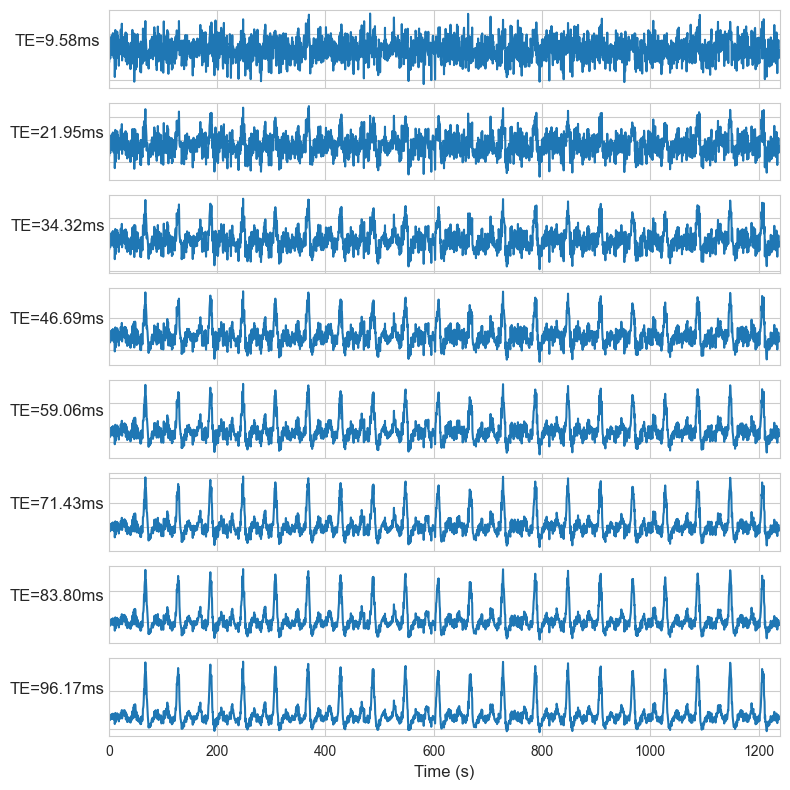

In [5]:
fig, axes = plt.subplots(figsize=(8, 8), nrows=len(echo_times), sharex=True)
for i_echo, echo_time in enumerate(echo_times):
    axes[i_echo].plot(frametimes, multiecho_signal[i_echo, :])
    axes[i_echo].set_ylabel(f"TE={echo_time:.2f}ms", fontsize=12, rotation="horizontal", labelpad=30, loc="center")
    axes[i_echo].set_yticklabels([])
axes[-1].set_xlim(0, np.max(frametimes))
axes[-1].set_xlabel("Time (s)", fontsize=12)
fig.tight_layout()
fig.savefig("02_simulated_data.png", dpi=400, bbox_inches="tight")

# Figure out the impact of condition T2* vs. data T2* on kappa and rho

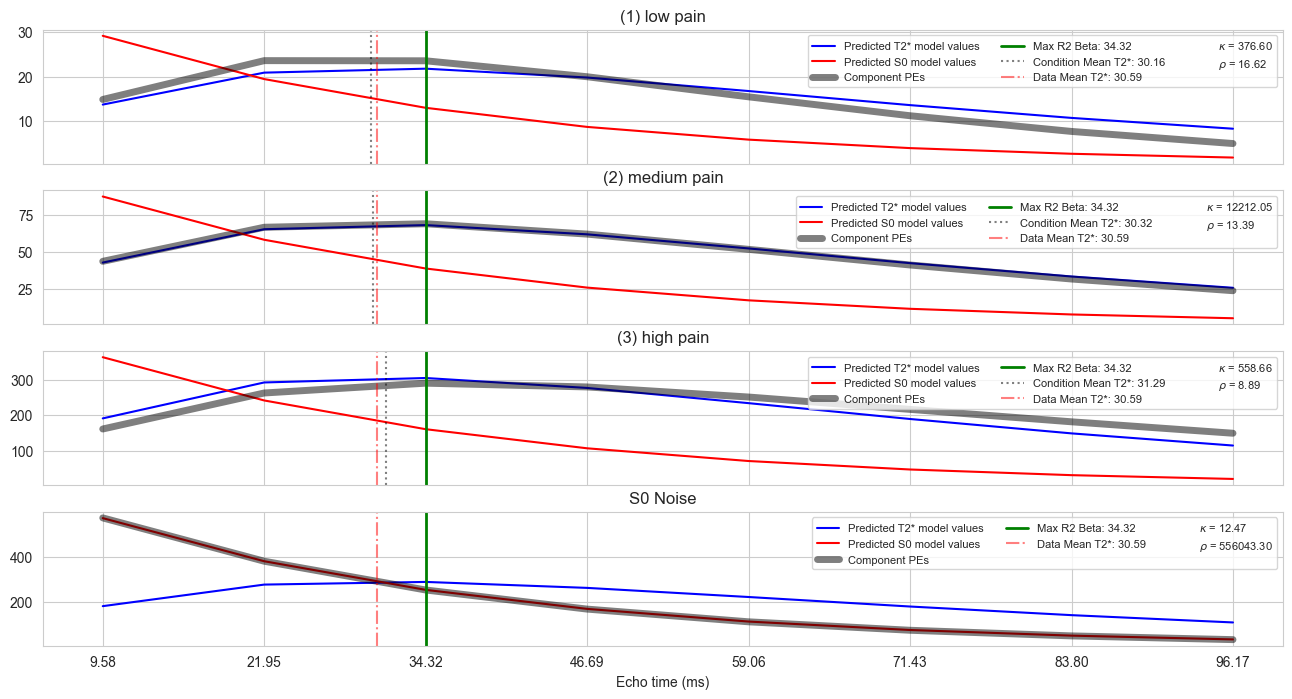

In [6]:
# Calculate condition-wise PEs using univariate regression in case of collinearity.
# This isn't ICA- the conditions aren't from the same source separation, so univariate should be valid.
pes = np.zeros((len(conditions), n_echoes))
for i_condition in range(len(conditions)):
    comp_X = np.vstack((components_dm[:, i_condition], np.ones(components_dm.shape[0]))).T
    cond_pes, _, _, _ = np.linalg.lstsq(comp_X, multiecho_signal.T, rcond=None)
    pes[i_condition, :] = cond_pes[0, :]

fig, axes = plt.subplots(nrows=len(conditions), figsize=(16, 8), sharex=True)
for i_condition, condition in enumerate(conditions):
    F_S0, F_R2, pred_S0, pred_R2 = compute_metrics(multiecho_signal, pes[i_condition, :], echo_times)
    rho, kappa = F_S0[0], F_R2[0]

    axes[i_condition].plot(echo_times, pred_R2, label='Predicted T2* model values', c='blue')
    axes[i_condition].plot(echo_times, pred_S0, label='Predicted S0 model values', c='red')
    axes[i_condition].plot(echo_times, pes[i_condition, :], label='Component PEs', alpha=0.5, linewidth=5, c='black')
    max_r2_beta = echo_times[np.where(np.abs(pred_R2) == np.max(np.abs(pred_R2)))[0]][0]
    axes[i_condition].axvline(
        max_r2_beta, 
        color='green',
        linewidth=2,
        label=f"Max R2 Beta: {max_r2_beta:.2f}",
    )
    if i_condition < (len(conditions) - 1):
        axes[i_condition].axvline(
            mean_t2ss[i_condition],
            color='black',
            linestyle='dotted',
            alpha=0.5,
            label=f"Condition Mean T2*: {mean_t2ss[i_condition]:.2f}",
        )
    axes[i_condition].axvline(
        np.mean(mean_t2ss),
        color='red',
        linestyle='dashdot',
        alpha=0.5,
        label=f"Data Mean T2*: {np.mean(mean_t2ss):.2f}",
    )
    axes[i_condition].plot(echo_times, pred_R2, label=r'$\kappa$ = {:.02f}'.format(kappa), alpha=0)
    axes[i_condition].plot(echo_times, pred_S0, label=r'$\rho$ = {:.02f}'.format(rho), alpha=0)
    axes[i_condition].set_title(condition)
    leg = axes[i_condition].legend(fontsize=8, ncol=3)

axes[i_condition].set_xlim(
    np.min(echo_times) - (np.min(echo_times) % 5), 
    np.max(echo_times) - (np.max(echo_times) % 5) + 5,
)
axes[i_condition].set_xlabel('Echo time (ms)')    
axes[i_condition].set_xticks(echo_times)
fig.savefig('03_component_model_fits.png', dpi=400, bbox_inches="tight")